GOLD PRICE PREDICTION - COMPREHENSIVE TRAINING
Ticker: GC=F
Lookback Days: 20

SECTION 2: FETCHING DATA


2026/01/07 15:54:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Downloaded 1258 days of data
  Date range: 2021-01-07 to 2026-01-07
✓ Saved to: ../data/raw/gold_raw_5y_20260107_155412.csv
Deleted old CSV: ../data/raw\gold_raw_5y_20260107_155301.csv

SECTION 3: FEATURE ENGINEERING
✓ Created 30 new features
✓ Final dataset: 1208 samples

SECTION 4: PREPARING DATA
✓ Train set: 966 samples
✓ Test set: 242 samples
✓ Features: 29

SECTION 6-10: TRAINING MODELS

📊 Training Ridge Regression...


2026/01/07 15:54:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   MAPE: 1.01%, Direction: 53.3%

📊 Training Random Forest...


2026/01/07 15:54:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 15:54:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   MAPE: 20.96%, Direction: 40.9%

📊 Training XGBoost...


2026/01/07 15:54:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 15:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   MAPE: 21.00%, Direction: 40.9%

📊 Training Gradient Boosting...


2026/01/07 15:54:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 15:54:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   MAPE: 21.19%, Direction: 40.9%

SECTION 11: MODEL COMPARISON
                        mape        rmse         mae  direction_accuracy
Ridge               1.006950   49.659971   35.829811           53.305785
Random Forest      20.956579  912.152037  782.458670           40.909091
XGBoost            20.995869  914.688816  784.061681           40.909091
Gradient Boosting  21.190609  921.511814  790.992539           40.909091

🏆 Best Model: Ridge (MAPE: 1.01%)



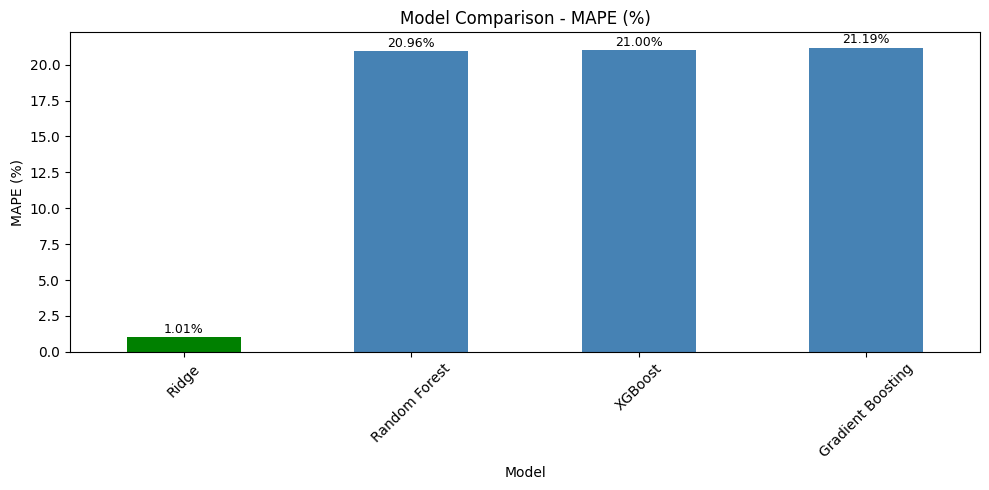


SECTION 12: SAVING BEST SKLEARN MODEL
✓ Saved: ../models/gold_sklearn_model.pkl
✓ Saved: ../models/gold_sklearn_scaler.pkl
✓ Saved: ../models/gold_sklearn_features.pkl
✓ Saved: ../models/sklearn_metadata.json

📌 Note: LSTM model files are preserved separately:
   - gold_lstm_model.keras (used by app.py for production)
   - gold_scaler.pkl
   - model_metadata.json (LSTM metrics)

SECTION 13: SUMMARY

✅ TRAINING COMPLETE!

🏆 Best sklearn Model: Ridge
    - MAPE: 1.01%
    - RMSE: $49.66
    - Direction Accuracy: 53.3%

📁 Models saved to ../models/:
    - gold_sklearn_model.pkl (best sklearn model)
    - gold_sklearn_scaler.pkl
    - gold_sklearn_features.pkl
    - sklearn_metadata.json
    
    - gold_lstm_model.keras (LSTM - used by app.py)
    - gold_scaler.pkl (LSTM scaler)
    - model_metadata.json (LSTM metrics)

📊 MLflow experiments at: ../mlruns/
🎯 Next Steps:
    1. View MLflow experiments: mlflow ui --port 5001
    2. Compare sklearn vs LSTM performance
    3. LSTM is used for 

In [7]:
"""
Gold Price Prediction - Comprehensive Training Pipeline
========================================================
This notebook trains multiple models, tracks with MLflow, and saves the best model.
"""

import os
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import json
import joblib
import glob

# ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# ============================================================================
# SECTION 1: CONFIGURATION
# ============================================================================
print("="*70)
print("GOLD PRICE PREDICTION - COMPREHENSIVE TRAINING")
print("="*70)

ticker = "GC=F"  # Gold Futures
LOOKBACK_DAYS = 20  # Consistent with LSTM training script

# Set MLflow tracking to project root
mlflow.set_tracking_uri("file:///" + os.path.abspath("../mlruns").replace("\\", "/"))
mlflow.set_experiment("gold_price_prediction_comprehensive")

print(f"Ticker: {ticker}")
print(f"Lookback Days: {LOOKBACK_DAYS}")
print()

# ============================================================================
# SECTION 2: DATA COLLECTION
# ============================================================================
print("="*70)
print("SECTION 2: FETCHING DATA")
print("="*70)

data = yf.download(ticker, period="5y", progress=False)

# Flatten MultiIndex columns if present (yfinance returns MultiIndex)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(f"✓ Downloaded {len(data)} days of data")
print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")

# Save to unified data folder with timestamp
os.makedirs('../data/raw', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = f'../data/raw/gold_raw_5y_{timestamp}.csv'
data.to_csv(csv_path)
print(f"✓ Saved to: {csv_path}")

# Delete old gold_raw_5y_*.csv files except the latest
csv_files = sorted(glob.glob('../data/raw/gold_raw_5y_*.csv'))
for old_file in csv_files[:-1]:
    try:
        os.remove(old_file)
        print(f"Deleted old CSV: {old_file}")
    except Exception as e:
        print(f"Could not delete {old_file}: {e}")
print()

# ============================================================================
# SECTION 3: FEATURE ENGINEERING
# ============================================================================
print("="*70)
print("SECTION 3: FEATURE ENGINEERING")
print("="*70)

featured_data = data.copy()

# Price features
featured_data['Returns'] = featured_data['Close'].pct_change()
featured_data['Log_Returns'] = np.log(featured_data['Close'] / featured_data['Close'].shift(1))

# Moving averages
for window in [5, 10, 20, 50]:
    featured_data[f'MA_{window}'] = featured_data['Close'].rolling(window=window).mean()
    featured_data[f'MA_Ratio_{window}'] = featured_data['Close'] / featured_data[f'MA_{window}']

# Volatility
for window in [5, 10, 20]:
    featured_data[f'Volatility_{window}'] = featured_data['Returns'].rolling(window=window).std()

# Momentum
for lag in [1, 5, 10, 20]:
    featured_data[f'Momentum_{lag}'] = featured_data['Close'] - featured_data['Close'].shift(lag)
    featured_data[f'ROC_{lag}'] = featured_data['Close'].pct_change(lag)

# High-Low features
featured_data['HL_Range'] = featured_data['High'] - featured_data['Low']
featured_data['HL_Pct'] = featured_data['HL_Range'] / featured_data['Close']

# Volume features
featured_data['Volume_MA_5'] = featured_data['Volume'].rolling(window=5).mean()
featured_data['Volume_Ratio'] = featured_data['Volume'] / featured_data['Volume_MA_5']

# Lag features
for lag in [1, 2, 3, 5]:
    featured_data[f'Close_Lag_{lag}'] = featured_data['Close'].shift(lag)

# Target: Next day's close price
featured_data['Target'] = featured_data['Close'].shift(-1)

# Drop NaN
featured_data = featured_data.dropna()

print(f"✓ Created {len(featured_data.columns) - len(data.columns)} new features")
print(f"✓ Final dataset: {len(featured_data)} samples")
print()

# ============================================================================
# SECTION 4: PREPARE DATA
# ============================================================================
print("="*70)
print("SECTION 4: PREPARING DATA")
print("="*70)

# Define features
exclude_cols = ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
feature_cols = [col for col in featured_data.columns if col not in exclude_cols]

X = featured_data[feature_cols]
y = featured_data['Target']

# Time series split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)

print(f"✓ Train set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")
print(f"✓ Features: {len(feature_cols)}")
print()

# ============================================================================
# SECTION 5: EVALUATION METRICS
# ============================================================================
def calculate_metrics(y_true, y_pred, y_current):
    """Calculate comprehensive metrics"""
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Direction accuracy
    actual_direction = np.sign(y_true.values - y_current.values)
    pred_direction = np.sign(y_pred - y_current.values)
    direction_accuracy = np.mean(actual_direction == pred_direction) * 100
    
    return {
        'mape': mape,
        'rmse': rmse,
        'mae': mae,
        'direction_accuracy': direction_accuracy
    }

# Get current prices for direction calculation
y_current = featured_data['Close'].iloc[split_idx:].reset_index(drop=True)
y_current_test = y_current[:len(y_test)]

# ============================================================================
# SECTION 6-10: TRAIN MODELS WITH MLFLOW
# ============================================================================
print("="*70)
print("SECTION 6-10: TRAINING MODELS")
print("="*70)

all_metrics = {}

# Model 1: Ridge Regression (optimized hyperparameters)
print("\n📊 Training Ridge Regression...")
with mlflow.start_run(run_name="Ridge_Regression"):
    ridge_model = Ridge(alpha=0.1)  # Optimized from hyperparameter tuning
    ridge_model.fit(X_train_scaled, y_train)
    ridge_pred = ridge_model.predict(X_test_scaled)
    ridge_metrics = calculate_metrics(y_test, ridge_pred, y_current_test)
    all_metrics['Ridge'] = ridge_metrics
    
    mlflow.log_params({'model_type': 'Ridge', 'alpha': 0.1})
    mlflow.log_metrics(ridge_metrics)
    mlflow.sklearn.log_model(ridge_model, "model")
    print(f"   MAPE: {ridge_metrics['mape']:.2f}%, Direction: {ridge_metrics['direction_accuracy']:.1f}%")

# Model 2: Random Forest (optimized hyperparameters)
print("\n📊 Training Random Forest...")
with mlflow.start_run(run_name="Random_Forest"):
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    )  # Optimized from hyperparameter tuning
    rf_model.fit(X_train_scaled, y_train)
    rf_pred = rf_model.predict(X_test_scaled)
    rf_metrics = calculate_metrics(y_test, rf_pred, y_current_test)
    all_metrics['Random Forest'] = rf_metrics

    mlflow.log_params({'model_type': 'RandomForest', 'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4})
    mlflow.log_metrics(rf_metrics)
    mlflow.sklearn.log_model(rf_model, "model")
    print(f"   MAPE: {rf_metrics['mape']:.2f}%, Direction: {rf_metrics['direction_accuracy']:.1f}%")

# Model 3: XGBoost (optimized hyperparameters)
print("\n📊 Training XGBoost...")
with mlflow.start_run(run_name="XGBoost"):
    xgb_model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42
    )  # Optimized from hyperparameter tuning
    xgb_model.fit(X_train_scaled, y_train)
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_metrics = calculate_metrics(y_test, xgb_pred, y_current_test)
    all_metrics['XGBoost'] = xgb_metrics

    mlflow.log_params({'model_type': 'XGBoost', 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.7})
    mlflow.log_metrics(xgb_metrics)
    mlflow.sklearn.log_model(xgb_model, "model")
    print(f"   MAPE: {xgb_metrics['mape']:.2f}%, Direction: {xgb_metrics['direction_accuracy']:.1f}%")

# Model 4: Gradient Boosting (optimized hyperparameters)
print("\n📊 Training Gradient Boosting...")
with mlflow.start_run(run_name="Gradient_Boosting"):
    gb_model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        random_state=42
    )  # Optimized from hyperparameter tuning
    gb_model.fit(X_train_scaled, y_train)
    gb_pred = gb_model.predict(X_test_scaled)
    gb_metrics = calculate_metrics(y_test, gb_pred, y_current_test)
    all_metrics['Gradient Boosting'] = gb_metrics

    mlflow.log_params({'model_type': 'GradientBoosting', 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.7})
    mlflow.log_metrics(gb_metrics)
    mlflow.sklearn.log_model(gb_model, "model")
    print(f"   MAPE: {gb_metrics['mape']:.2f}%, Direction: {gb_metrics['direction_accuracy']:.1f}%")

print()

# ============================================================================
# SECTION 11: MODEL COMPARISON
# ============================================================================
print("="*70)
print("SECTION 11: MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame(all_metrics).T
comparison_df = comparison_df.sort_values('mape')
print(comparison_df.to_string())
print()

# Find best model
best_model_name = comparison_df['mape'].idxmin()
best_mape = comparison_df.loc[best_model_name, 'mape']
best_metrics = all_metrics[best_model_name]

# Get the actual best model object
if best_model_name == 'Ridge':
    best_model = ridge_model
    best_pred = ridge_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_pred = rf_pred
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    best_pred = xgb_pred
else:
    best_model = gb_model
    best_pred = gb_pred

print(f"🏆 Best Model: {best_model_name} (MAPE: {best_mape:.2f}%)")
print()

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
bars = comparison_df['mape'].plot(kind='bar', ax=ax, color=['green' if x == best_model_name else 'steelblue' for x in comparison_df.index])
ax.set_title('Model Comparison - MAPE (%)')
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Model')
for bar in ax.patches:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.2f}%', ha='center', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print()

# ============================================================================
# SECTION 12: SAVE BEST SKLEARN MODEL (separate from LSTM)
# ============================================================================
print("="*70)
print("SECTION 12: SAVING BEST SKLEARN MODEL")
print("="*70)

os.makedirs('../models', exist_ok=True)

# Save sklearn model with distinct names (don't overwrite LSTM files)
joblib.dump(best_model, '../models/gold_sklearn_model.pkl')
print("✓ Saved: ../models/gold_sklearn_model.pkl")
joblib.dump(scaler, '../models/gold_sklearn_scaler.pkl')
print("✓ Saved: ../models/gold_sklearn_scaler.pkl")
joblib.dump(feature_cols, '../models/gold_sklearn_features.pkl')
print("✓ Saved: ../models/gold_sklearn_features.pkl")

# Save sklearn metadata (separate from LSTM metadata)
sklearn_metadata = {
    'model_type': best_model_name,
    'mape': float(best_metrics['mape']),
    'rmse': float(best_metrics['rmse']),
    'mae': float(best_metrics['mae']),
    'direction_accuracy': float(best_metrics['direction_accuracy']),
    'n_features': len(feature_cols),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'timestamp': datetime.now().isoformat()
}

with open('../models/sklearn_metadata.json', 'w') as f:
    json.dump(sklearn_metadata, f, indent=2)
print("✓ Saved: ../models/sklearn_metadata.json")

print()
print("📌 Note: LSTM model files are preserved separately:")
print("   - gold_lstm_model.keras (used by app.py for production)")
print("   - gold_scaler.pkl")
print("   - model_metadata.json (LSTM metrics)")
print()

# ============================================================================
# SECTION 13: SUMMARY & NEXT STEPS
# ============================================================================
print("="*70)
print("SECTION 13: SUMMARY")
print("="*70)

print(f"""
✅ TRAINING COMPLETE!

🏆 Best sklearn Model: {best_model_name}
    - MAPE: {best_metrics['mape']:.2f}%
    - RMSE: ${best_metrics['rmse']:.2f}
    - Direction Accuracy: {best_metrics['direction_accuracy']:.1f}%

📁 Models saved to ../models/:
    - gold_sklearn_model.pkl (best sklearn model)
    - gold_sklearn_scaler.pkl
    - gold_sklearn_features.pkl
    - sklearn_metadata.json
    
    - gold_lstm_model.keras (LSTM - used by app.py)
    - gold_scaler.pkl (LSTM scaler)
    - model_metadata.json (LSTM metrics)

📊 MLflow experiments at: ../mlruns/
🎯 Next Steps:
    1. View MLflow experiments: mlflow ui --port 5001
    2. Compare sklearn vs LSTM performance
    3. LSTM is used for production (app.py)
""")
print("="*70)
print("🎉 ALL DONE!")
print("="*70)